# Example 1: univariate regression

The goal is to predict a single scalar output $y \in \mathbb{R}$ from input $x$ using a model $f_\phi(x)$ with parameters $\phi$.

We select the univariate normal, which is defined over $y \in \mathbb{R}$. This distribution has two parameters (mean $\mu$ and variance $\sigma^2$).

$$
p(y|\mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left[-\frac{(y-\mu)^2}{2\sigma^2}\right]
$$

We set the machine learning model to compute the mean.
$$
\mu = f_\phi(x)
$$

We choose a loss function based on the negative log-likelihood.
$$
\begin{align}
L(\phi) & = -\sum_{i=1}^{I}\log p(y_i|f_\phi(x_i), \sigma^2) \\
& = -\sum_{i=1}^{I}\log\left[ \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left[-\frac{(y-f_\phi(x))^2}{2\sigma^2}\right] \right]
\end{align}
$$

When the train the model, we seek parameters $\hat{\phi}$ that minimize the loss.
$$
\begin{align}
\hat{\phi} & = \underset{\phi}{\mathrm{argmin}}\left[
  -\sum_{i=1}^{I}\log\left[ \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left[-\frac{(y-f_\phi(x))^2}{2\sigma^2}\right] \right]
  \right] \\
& = \underset{\phi}{\mathrm{argmin}}\left[
  -\sum_{i=1}^{I}
  \left( \log \left[\frac{1}{\sqrt{2\pi\sigma^2}} \right]
  -\frac{(y-f_\phi(x))^2}{2\sigma^2} \right) \right]\\
& = \underset{\phi}{\mathrm{argmin}}\left[
  -\sum_{i=1}^{I}
  \left(
  -\frac{(y-f_\phi(x))^2}{2\sigma^2} \right) \right]\\
& = \underset{\phi}{\mathrm{argmin}}\left[
  \sum_{i=1}^{I} (y-f_\phi(x))^2 \right]\\
\end{align}
$$

Therefore, we have a **least squares loss** function.

$$
L(\phi) = \sum_{i=1}^{I} (y_i-f_\phi(x_i))^2
$$

When we perform inference, we usually want a single "best" point estimate $\hat{y}$, so we take the maximum of the predicted distribution:

$$
\hat{y} = \underset{\phi}{\mathrm{argmax}} \; p(y|f_\hat{\phi}(x), \sigma^2)
$$

For the univariate normal, the maximum position is determined by the mean parameter $\mu$. This is precisely what the model computed, so

$$
\hat{y} = f_\hat{\phi}(x)
$$

## Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

## Data

In [ ]:
# Data
# y = 2x + 5
N = 100
x = torch.linspace(-10, 10, N).view(-1, 1)  #(N, 1)
x.shape

torch.Size([100, 1])

In [ ]:
noise = torch.randn_like(x) * 2
y = 2*x + 5 + noise
y.shape

torch.Size([100, 1])

In [ ]:
def y_true(x):
  return 2*x + 5

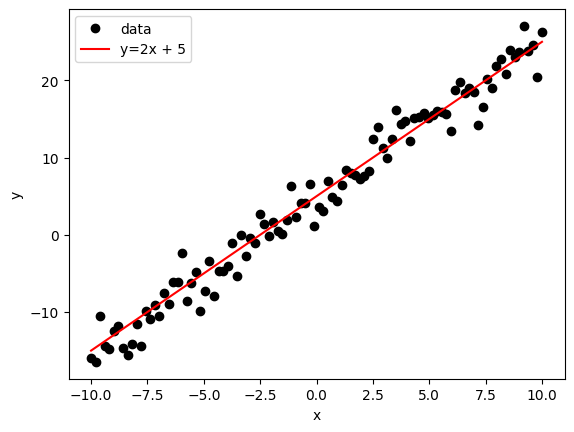

In [ ]:
plt.figure()
plt.plot(x, y, 'o', label='data', color='black')
plt.plot(x, y_true(x), '-', label='y=2x + 5', color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## Dataset, DataLoader

In [ ]:
class RegressionDataset(Dataset):
    def __init__(self, N=100):
        x = torch.linspace(-10, 10, N).view(-1, 1)
        noise = torch.randn_like(x) * 2
        y = 2*x + 5 + noise
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [ ]:
dataset = RegressionDataset()
len(dataset)

100

In [ ]:
sample = dataset[0]
sample

(tensor([-10.]), tensor([-14.6443]))

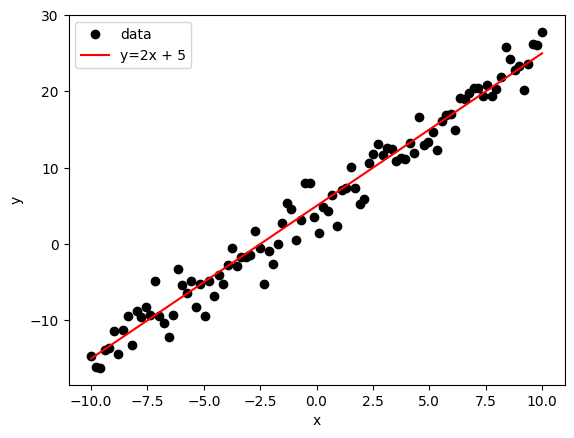

In [ ]:
plt.figure()
plt.plot(dataset.x, dataset.y, 'o', label='data', color='black')
plt.plot(dataset.x, y_true(dataset.x), '-', label='y=2x + 5', color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [ ]:
dataloader = DataLoader(dataset, batch_size=2, shuffle=False)
batch = next(iter(dataloader))
batch

[tensor([[-10.0000],
         [ -9.7980]]),
 tensor([[-14.6443],
         [-16.1568]])]

In [ ]:
type(batch)

list

In [ ]:
for s in dataloader:
  s
  break

In [ ]:
s

[tensor([[-10.0000],
         [ -9.7980]]),
 tensor([[-14.6443],
         [-16.1568]])]

In [ ]:
dataset[0]

(tensor([-10.]), tensor([-14.6443]))

In [ ]:
dataset[1]

(tensor([-9.7980]), tensor([-16.1568]))

## torch.nn

In [ ]:
layer = nn.Linear(1, 3)
layer

Linear(in_features=1, out_features=3, bias=True)

In [ ]:
inputs = batch[0]
print(inputs)
inputs.shape  # (batch_size, 1)

tensor([[-10.0000],
        [ -9.7980]])


torch.Size([2, 1])

In [ ]:
outputs = layer(inputs)
print(outputs)
outputs.shape

tensor([[-3.5345, -8.6907,  7.4134],
        [-3.4572, -8.5273,  7.2691]], grad_fn=<AddmmBackward0>)


torch.Size([2, 3])

In [ ]:
params = []
for p in layer.parameters():
  print(p, end='\n\n')
  params.append(p.data)

Parameter containing:
tensor([[ 0.3825],
        [ 0.8085],
        [-0.7144]], requires_grad=True)

Parameter containing:
tensor([ 0.2904, -0.6056,  0.2699], requires_grad=True)



In [ ]:
A = params[0]  # weight
A.shape

torch.Size([3, 1])

In [ ]:
b = params[1]  # bias
b.shape

torch.Size([3])

### nn.Linear

https://pytorch.org/docs/stable/generated/torch.nn.Linear.html

$$
y = x A^T + b
$$

- $x$: Input $(N, d_\text{in})$
- $A$: Weight matrix $(d_\text{out}, d_\text{in})$
  - $A^T$: Transpose of $A$ $(d_\text{in}, d_\text{out})$
- $b$: Bias $(d_\text{out})$

$$
(N, d_\text{in}) \times (d_\text{in}, d_\text{out}) + (d_\text{out}) \rightarrow (N, d_\text{out})
$$

In [ ]:
# (N, d_out)
intermediate = inputs @ A.T
print(intermediate)
intermediate.shape

tensor([[-3.8249, -8.0851,  7.1435],
        [-3.7476, -7.9217,  6.9992]])


torch.Size([2, 3])

In [ ]:
print(b)
print(b.shape)

tensor([ 0.2904, -0.6056,  0.2699])
torch.Size([3])


In [ ]:
print(intermediate[0, :])
intermediate[0, :] + b

tensor([-3.8249, -8.0851,  7.1435])


tensor([-3.5345, -8.6907,  7.4134])

In [ ]:
print(intermediate[1, :])
intermediate[1, :] + b

tensor([-3.7476, -7.9217,  6.9992])


tensor([-3.4572, -8.5273,  7.2691])

### Broadcasting

https://numpy.org/doc/stable/user/basics.broadcasting.html

The term broadcasting describes how NumPy treats arrays with different shapes during arithmetic operations. Subject to certain constraints, the smaller array is “broadcast” across the larger array so that they have compatible shapes. Broadcasting provides a means of vectorizing array operations so that looping occurs in C instead of Python. It does this without making needless copies of data and usually leads to efficient algorithm implementations. There are, however, cases where broadcasting is a bad idea because it leads to inefficient use of memory that slows computation.

#### General broadcasting rules
When operating on two arrays, NumPy compares their shapes element-wise. It starts with the trailing (i.e. rightmost) dimension and works its way left. Two dimensions are compatible when

- they are equal, or

- one of them is 1.

If these conditions are not met, a `ValueError: operands could not be broadcast together` exception is thrown, indicating that the arrays have incompatible shapes.

Input arrays do not need to have the same number of dimensions. The resulting array will have the same number of dimensions as the input array with the greatest number of dimensions, where the size of each dimension is the largest size of the corresponding dimension among the input arrays. **Note that missing dimensions are assumed to have size one**.

In [ ]:
# broadcasting
# (N, d_out) + (d_out) =>
# (N, d_out) + (1, d_out) =>
# (N, d_out) + (N, d_out) =>
# (N, d_out)
print(b)
output_manual = inputs @ A.T + b
print(output_manual)
output_manual.shape

tensor([ 0.2904, -0.6056,  0.2699])
tensor([[-3.5345, -8.6907,  7.4134],
        [-3.4572, -8.5273,  7.2691]])


torch.Size([2, 3])

In [ ]:
layer(inputs)

tensor([[-3.5345, -8.6907,  7.4134],
        [-3.4572, -8.5273,  7.2691]], grad_fn=<AddmmBackward0>)

## Model

In [ ]:
# Define Model
class RegressionModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Linear(1, 1)

    def forward(self, x):
        return self.model(x)

In [ ]:
inputs

tensor([[-10.0000],
        [ -9.7980]])

In [ ]:
model = RegressionModel()
model(inputs)

tensor([[4.2022],
        [4.1316]], grad_fn=<AddmmBackward0>)

In [ ]:
params = []
for p in model.parameters():
  print(p)
  params.append(p.data)

Parameter containing:
tensor([[-0.3494]], requires_grad=True)
Parameter containing:
tensor([0.7086], requires_grad=True)


In [ ]:
# y = x A^T + b
inputs @ params[0].T + params[1]

tensor([[4.2022],
        [4.1316]])

- Mean squared error (MSE)

$$
\text{MSE}(a,b) = \frac{1}{N}\sum_i^N(a_i - b_i)^2
$$

In [ ]:
mse = nn.MSELoss()
a = torch.FloatTensor([1, 2])
b = torch.FloatTensor([4, 5])
mse(a, b)

tensor(9.)

## Training

In [ ]:
# Initialize model, loss function(criterion), optimizer
model = RegressionModel()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 200
losses = []
for epoch in range(num_epochs):
    train_loss = 0.0
    for batch in dataloader:
        x, y = batch

        # Foward propagation
        predictions = model(x)
        loss = criterion(predictions, y)

        # Backpropagation and update weights & biases
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Save loss
        train_loss += loss.item()

    train_loss /= len(dataloader)
    losses.append(train_loss)

    if epoch % 10 == 0:
        print(f"Epoch [{epoch:3d}], Loss: {train_loss:.4f}")

Epoch [  0], Loss: 101.7161
Epoch [ 10], Loss: 17.1326
Epoch [ 20], Loss: 14.8129
Epoch [ 30], Loss: 12.8773
Epoch [ 40], Loss: 11.2902
Epoch [ 50], Loss: 9.9914
Epoch [ 60], Loss: 8.9286
Epoch [ 70], Loss: 8.0590
Epoch [ 80], Loss: 7.3474
Epoch [ 90], Loss: 6.7653
Epoch [100], Loss: 6.2889
Epoch [110], Loss: 5.8992
Epoch [120], Loss: 5.5803
Epoch [130], Loss: 5.3194
Epoch [140], Loss: 5.1060
Epoch [150], Loss: 4.9314
Epoch [160], Loss: 4.7886
Epoch [170], Loss: 4.6717
Epoch [180], Loss: 4.5762
Epoch [190], Loss: 4.4980


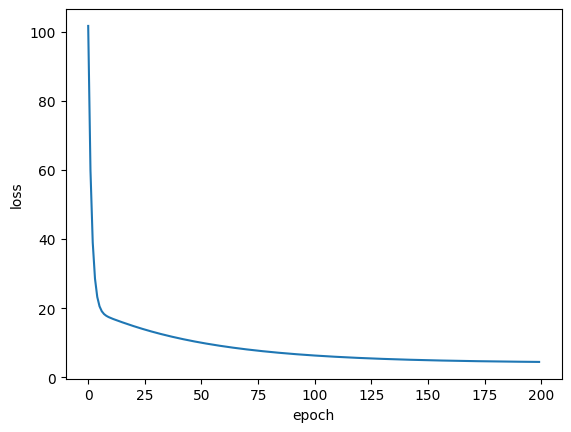

In [ ]:
plt.figure()
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
print(model(dataset.x))

tensor([[-1.6060e+01],
        [-1.5648e+01],
        [-1.5236e+01],
        [-1.4824e+01],
        [-1.4412e+01],
        [-1.4000e+01],
        [-1.3588e+01],
        [-1.3176e+01],
        [-1.2764e+01],
        [-1.2352e+01],
        [-1.1940e+01],
        [-1.1528e+01],
        [-1.1116e+01],
        [-1.0704e+01],
        [-1.0292e+01],
        [-9.8801e+00],
        [-9.4681e+00],
        [-9.0561e+00],
        [-8.6441e+00],
        [-8.2320e+00],
        [-7.8200e+00],
        [-7.4080e+00],
        [-6.9960e+00],
        [-6.5840e+00],
        [-6.1720e+00],
        [-5.7600e+00],
        [-5.3479e+00],
        [-4.9359e+00],
        [-4.5239e+00],
        [-4.1119e+00],
        [-3.6999e+00],
        [-3.2879e+00],
        [-2.8759e+00],
        [-2.4638e+00],
        [-2.0518e+00],
        [-1.6398e+00],
        [-1.2278e+00],
        [-8.1579e-01],
        [-4.0377e-01],
        [ 8.2426e-03],
        [ 4.2026e-01],
        [ 8.3227e-01],
        [ 1.2443e+00],
        [ 1

In [ ]:
with torch.inference_mode():
    print(model(dataset.x))

tensor([[-1.6060e+01],
        [-1.5648e+01],
        [-1.5236e+01],
        [-1.4824e+01],
        [-1.4412e+01],
        [-1.4000e+01],
        [-1.3588e+01],
        [-1.3176e+01],
        [-1.2764e+01],
        [-1.2352e+01],
        [-1.1940e+01],
        [-1.1528e+01],
        [-1.1116e+01],
        [-1.0704e+01],
        [-1.0292e+01],
        [-9.8801e+00],
        [-9.4681e+00],
        [-9.0561e+00],
        [-8.6441e+00],
        [-8.2320e+00],
        [-7.8200e+00],
        [-7.4080e+00],
        [-6.9960e+00],
        [-6.5840e+00],
        [-6.1720e+00],
        [-5.7600e+00],
        [-5.3479e+00],
        [-4.9359e+00],
        [-4.5239e+00],
        [-4.1119e+00],
        [-3.6999e+00],
        [-3.2879e+00],
        [-2.8759e+00],
        [-2.4638e+00],
        [-2.0518e+00],
        [-1.6398e+00],
        [-1.2278e+00],
        [-8.1579e-01],
        [-4.0377e-01],
        [ 8.2426e-03],
        [ 4.2026e-01],
        [ 8.3227e-01],
        [ 1.2443e+00],
        [ 1

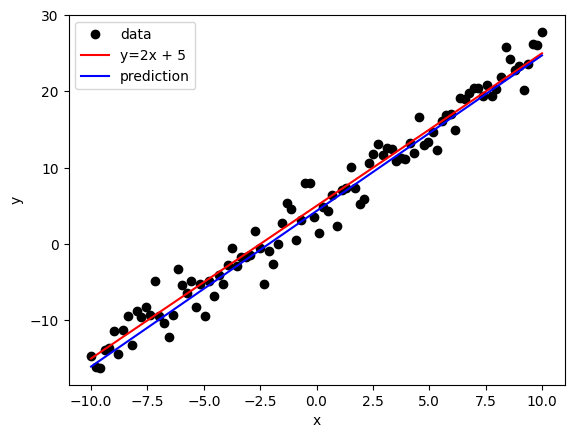

In [ ]:
# with torch.no_grad():
with torch.inference_mode():
    y_pred = model(dataset.x)

plt.figure()
plt.plot(dataset.x, dataset.y, 'o', label='data', color='black')
plt.plot(dataset.x, y_true(dataset.x), '-', label='y=2x + 5', color='red')
plt.plot(dataset.x, y_pred, '-', label='prediction', color='blue')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [ ]:
params = []
for p in model.parameters():
  print(p)
  params.append(p.data)

Parameter containing:
tensor([[2.0395]], requires_grad=True)
Parameter containing:
tensor([4.3344], requires_grad=True)


In [ ]:
y_pred_manual = dataset.x @ params[0].T + params[1]
torch.allclose(y_pred, y_pred_manual)

True

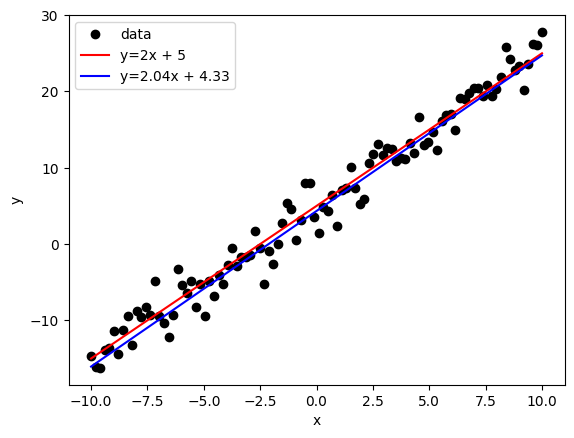

In [ ]:
if params[1].item() > 0:
  label = f'y={params[0].item():.2f}x + {params[1].item():.2f}'
else:
  label = f'y={params[0].item():.2f}x - {abs(params[1].item()):.2f}'

plt.figure()
plt.plot(dataset.x, dataset.y, 'o', label='data', color='black')
plt.plot(dataset.x, y_true(dataset.x), '-', label='y=2x + 5', color='red')
plt.plot(dataset.x, y_pred, '-', label=label, color='blue')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## Summary

Epoch [  0], Loss: 107.9759
Epoch [ 10], Loss: 29.9670
Epoch [ 20], Loss: 25.0065
Epoch [ 30], Loss: 20.9828
Epoch [ 40], Loss: 17.6925
Epoch [ 50], Loss: 15.0126
Epoch [ 60], Loss: 12.8089
Epoch [ 70], Loss: 11.0059
Epoch [ 80], Loss: 9.5311
Epoch [ 90], Loss: 8.3223
Epoch [100], Loss: 7.3317
Epoch [110], Loss: 6.5270
Epoch [120], Loss: 5.8648
Epoch [130], Loss: 5.3208
Epoch [140], Loss: 4.8767
Epoch [150], Loss: 4.5159
Epoch [160], Loss: 4.2218
Epoch [170], Loss: 3.9780
Epoch [180], Loss: 3.7783
Epoch [190], Loss: 3.6155


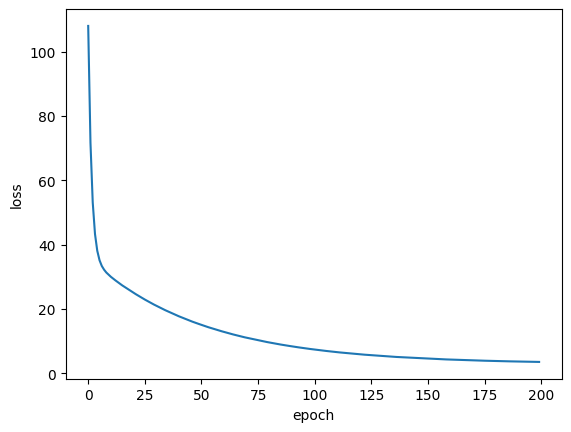

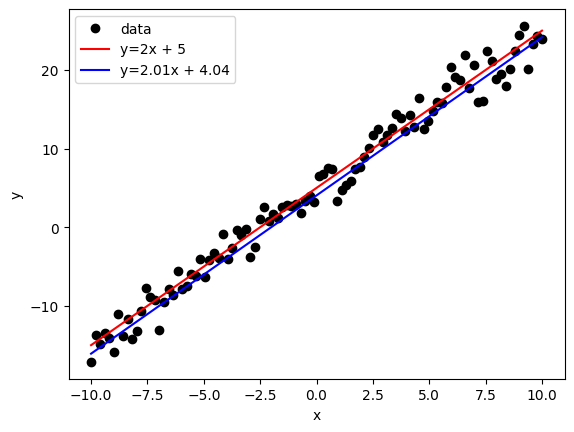

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Define Dataset
class RegressionDataset(Dataset):
    def __init__(self, N=100):
        x = torch.linspace(-10, 10, N).view(-1, 1)
        noise = torch.randn_like(x) * 2
        y = 2*x + 5 + noise
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# Define Model
class RegressionModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Linear(1, 1)

    def forward(self, x):
        return self.model(x)

# Dataset, DataLoader
dataset = RegressionDataset()
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# Model, Optimizer, Criterion
model = RegressionModel()
optimizer = optim.SGD(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

# Training loop
num_epochs = 200
losses = []
for epoch in range(num_epochs):
    train_loss = 0.0
    for batch in dataloader:
        x, y = batch

        # Foward propagation
        predictions = model(x)
        loss = criterion(predictions, y)

        # Backpropagation and update weights & biases
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Save loss
        train_loss += loss.item()

    train_loss /= len(dataloader)
    losses.append(train_loss)

    if epoch % 10 == 0:
        print(f"Epoch [{epoch:3d}], Loss: {train_loss:.4f}")

# Loss curve
plt.figure()
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

# Inference
def get_label(model):
    params = []
    for p in model.parameters():
        params.append(p.data)
    if params[1].item() > 0:
      label = f'y={params[0].item():.2f}x + {params[1].item():.2f}'
    else:
      label = f'y={params[0].item():.2f}x - {abs(params[1].item()):.2f}'
    return label

with torch.inference_mode():
    y_pred = model(dataset.x)

label = get_label(model)

plt.figure()
plt.plot(dataset.x, dataset.y, 'o', label='data', color='black')
plt.plot(dataset.x, y_true(dataset.x), '-', label='y=2x + 5', color='red')
plt.plot(dataset.x, y_pred, '-', label=label, color='blue')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## PyTorch Lightning

In [ ]:
!pip install -qq lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 42.8 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger

# Define Dataset
class RegressionDataset(Dataset):
    def __init__(self, N=100):
        x = torch.linspace(-10, 10, N).view(-1, 1)
        noise = torch.randn_like(x) * 2
        y = 2*x + 5 + noise
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# Define Model
class RegressionModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Linear(1, 1)

    def forward(self, x):
        return self.model(x)

# LightningDataModule
class LiTRegressionDataModule(L.LightningDataModule):
    def __init__(self, batch_size=2):
        super().__init__()
        self.batch_size = batch_size

    def setup(self, stage):
        self.dataset_train = RegressionDataset()

    def train_dataloader(self):
        return DataLoader(self.dataset_train, batch_size=self.batch_size, shuffle=True)

# LightningModule
class LiTRegressionModel(L.LightningModule):
    def __init__(self, lr=0.0001):
        super().__init__()
        self.save_hyperparameters()

        self.model = RegressionModel()
        self.lr = lr

        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        predictions = self(x)
        loss = self.criterion(predictions, y)
        self.log("train/loss", loss, prog_bar=True, on_epoch=True, on_step=False)
        return loss

    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=self.lr)
        return optimizer

# Data, Model
dm = LiTRegressionDataModule()
model_lit = LiTRegressionModel(lr=0.005)

# Trainer
callbacks = [
    ModelCheckpoint(save_top_k=1, mode="min", monitor="train/loss"),
]
logger = CSVLogger(save_dir="logs/", name="regression")

trainer = L.Trainer(
    max_epochs=20,
    callbacks = callbacks,
    logger = logger
)

# Training
trainer.fit(model_lit, dm)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name      | Type            | Params | Mode 
------------------------------------------------------
0 | model     | RegressionModel | 2      | train
1 | criterion | MSELoss         | 0      | train
------------------------------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name      | Type            | Params | Mode 
------------------------------------------------------
0 | model     | Regres

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
trainer.logger.log_dir

'logs/regression/version_0'

In [ ]:
import pandas as pd

In [ ]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
metrics.head()

,epoch,step,train/loss
0,0,49,25.412720
1,1,99,12.479750
2,2,149,7.366966
3,3,199,5.508699
4,4,249,4.844038


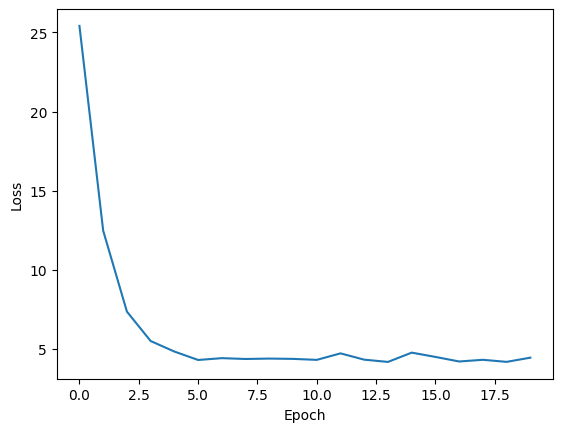

In [ ]:
metrics["train/loss"].plot(xlabel="Epoch", ylabel="Loss");

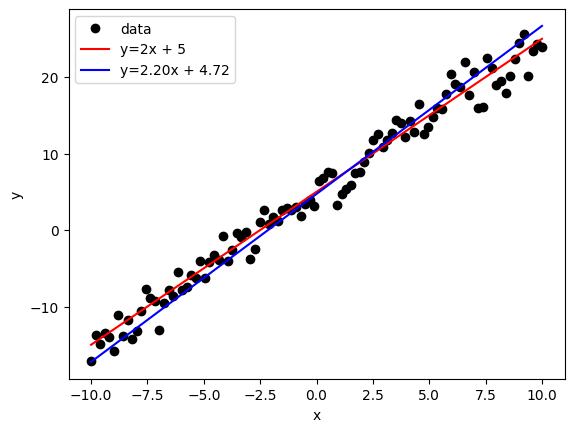

In [ ]:
with torch.inference_mode():
    y_pred = model_lit(dm.dataset_train.x)

label = get_label(model_lit)

plt.figure()
plt.plot(dataset.x, dataset.y, 'o', label='data', color='black')
plt.plot(dataset.x, y_true(dataset.x), '-', label='y=2x + 5', color='red')
plt.plot(dataset.x, y_pred, '-', label=label, color='blue')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()